
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 2, 3, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 2, 3, 3)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 7.19s


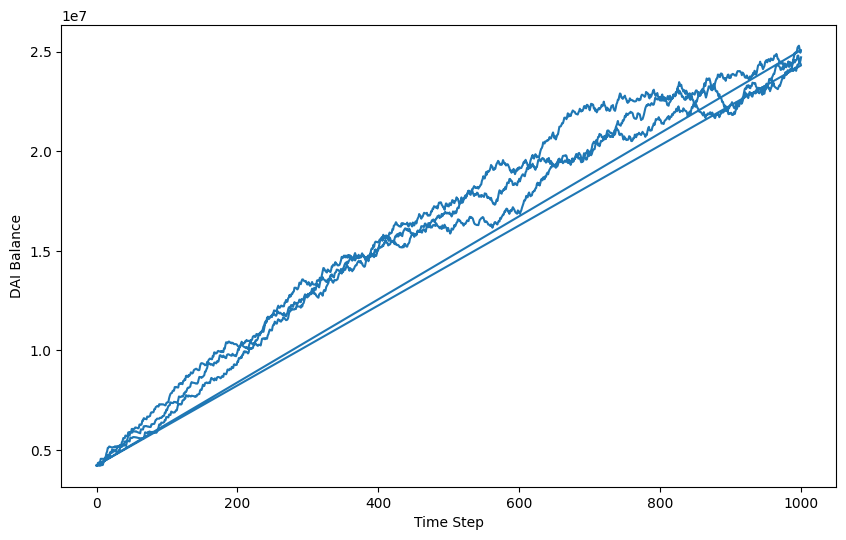

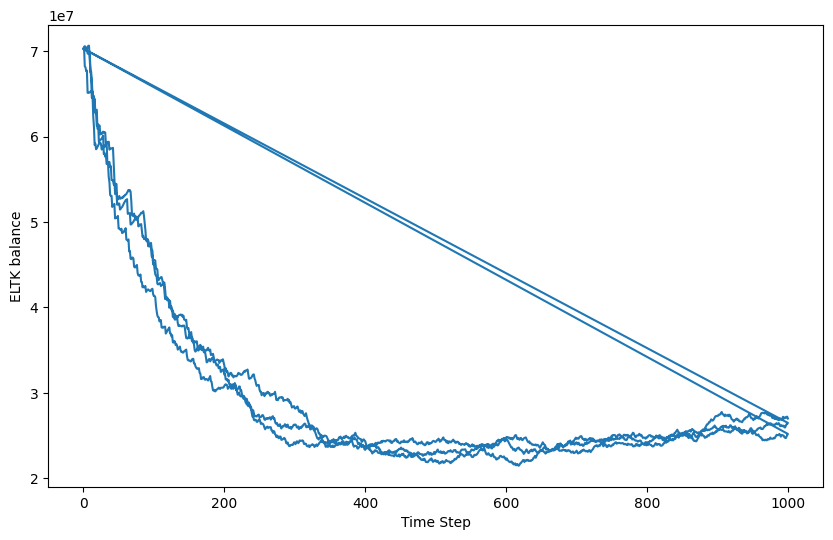

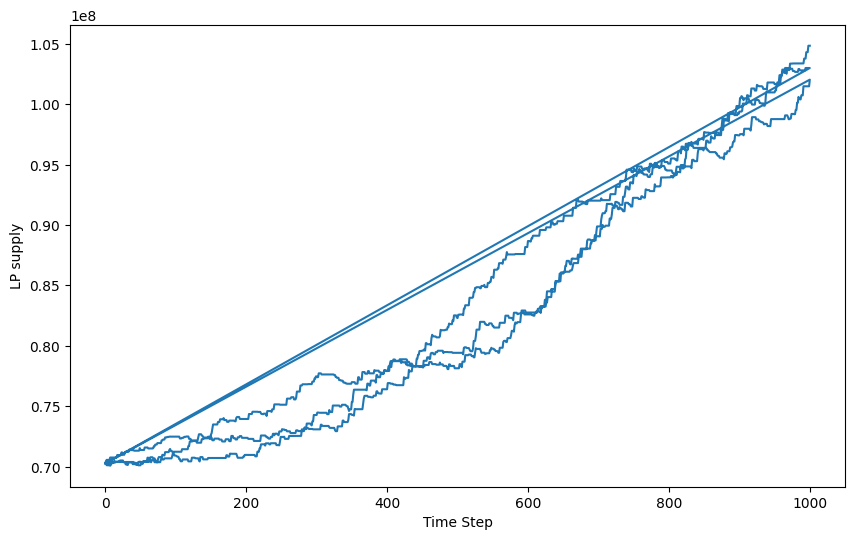

In [13]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 200  # average rate of liquidity removals per unit time
TIMESTEPS=1000
RUNS=3

state = {
    'DAI_balance': 4216667,
    'ELTK_balance': 70277778
}
state['LP_shares'] = state['ELTK_balance']
params = {
    'fee_numerator': [997],
    'fee_denominator': [1000]
}

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ELTK_reserve = int(current_state['ELTK_balance'])
    liquidity_minted = int(input_['ELTK_deposit'] * total_liquidity // ELTK_reserve)
    return ('LP_shares', total_liquidity + liquidity_minted)

def addLiquidity_ELTK(params, step, history, current_state, input_):
    ELTK_reserve = int(current_state['ELTK_balance'])
    return ('ELTK_balance', ELTK_reserve + input_['ELTK_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    ELTK_reserve = int(current_state['ELTK_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['ELTK_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['ELTK_deposit'] * token_reserve // ELTK_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ELTK(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ELTK_reserve = int(current_state['ELTK_balance'])
    amount = int(input_['LP_burn'])
    ELTK_amount = int(amount * ELTK_reserve // total_liquidity)
    return ('ELTK_balance', int(ELTK_reserve - ELTK_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ELTK-token
#ELTK sold/deposited
def ELTKToToken_ELTK(params, step, history, current_state, input_):
    ELTK_sold = int(input_['ELTK_sold']) #amount of ELTK being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    return ('ELTK_balance', ELTK_reserve + ELTK_sold)

#DAI received
def ELTKToToken_DAI(params, step, history, current_state, input_):
    ELTK_sold = int(input_['ELTK_sold']) #amount of ELTK being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if ELTK_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(ELTK_sold, ELTK_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ELTK
 #ELTK recieved   
def tokenToELTK_ELTK(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    if tokens_sold == 0:
        return ('ELTK_balance', ELTK_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        ELTK_bought = int(getInputPrice(tokens_sold, token_reserve, ELTK_reserve, params))
        return ('ELTK_balance', ELTK_reserve - ELTK_bought)

 #tokens sold/depoisted   
def tokenToELTK_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


import random
import numpy as np

def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'ELTK_sold': 0,
        'tokens_sold': 0,
        'ELTK_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event based on probability distribution
    events = ['TokenPurchase', 'ELTKPurchase', 'AddLiquidity', 'Transfer']
    event_probabilities = [0.35, 0.35, 0.15, 0.15]  # Example probabilities for each event
    event = np.random.choice(events, p=event_probabilities)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Generate random values for eLTK_sold using a specific distribution
        ELTK_sold = random.uniform(0, 200000)#np.random.normal(loc=5, scale=2000)  # Example using normal distribution
        action['ELTK_sold'] = max(ELTK_sold, 0)  # Ensure non-negative value
    elif event == 'ELTKPurchase':
        # Generate random values for tokens_sold using a specific distribution
        tokens_sold = np.random.uniform(0, 200000)  # Example using uniform distribution
        action['tokens_sold'] = tokens_sold
    elif event == 'AddLiquidity':
        # Generate random values for ELTK_deposit using a specific distribution
        ELTK_deposit = random.uniform(0, 200000)#np.random.exponential(scale=2000)  # Example using exponential distribution
        action['ELTK_deposit'] = ELTK_deposit
    elif event == 'Transfer':
        # Generate random values for LP_burn using a specific distribution
        LP_burn = random.uniform(0, 200000)#np.random.poisson(lam=2000)  # Example using Poisson distribution
        action['LP_burn'] = LP_burn

    return action

def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ELTKToToken_DAI(params, step, history, current_state, input_)
    elif action == 'ELTKPurchase':
        return tokenToELTK_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ELTK(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ELTKToToken_ELTK(params, step, history, current_state, input_)
    elif action == 'ELTKPurchase':
        return tokenToELTK_ELTK(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ELTK(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ELTK(params, step, history, current_state, input_)
    return('ELTK_balance', current_state['ELTK_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    

partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ELTK_balance': mechanismHub_ELTK,
            'LP_shares': mechanismHub_LP
        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['ELTK_balance'])
plt.xlabel('Time Step')
plt.ylabel('ELTK balance')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')
plt.show()